In [1]:
import sys
import matplotlib
import tensorflow as tf
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.append("/Users/riley/PycharmProjects/ML")
from utils.dataframe import DataFrame
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"
df = DataFrame.read_tar(url)
test_size = 0.2
random_state = 42
figsize=(12,8)

/Users/riley/PycharmProjects/ML/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


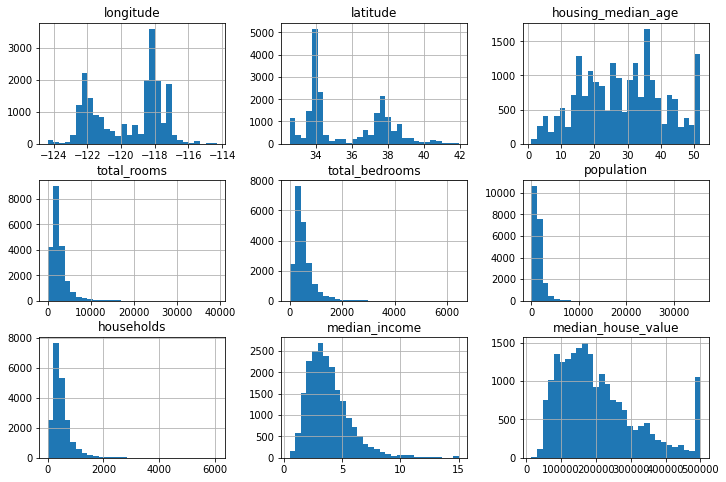

In [2]:
df.hist(figsize=figsize, bins=30);

In [3]:
y_col = "median_house_value"
X_cols = list(df.columns)
X_cols.remove(y_col)
train_set, test_set = train_test_split(df, test_size=test_size, random_state=random_state)

Need to figure out how to deal with long tail distributions like total_rooms, population, etc. This is point number 4.

In [4]:
corr = df.corr()
corr[y_col].sort_values()

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

^ This is telling us that the most correlated feature (quite strongly) is median_income. And then we can deduce that we should be stratifying our train/test split based on that. I think we can do better than what Geron does by doing the following:

[ 0.4999      1.96534444  2.45416667  2.89196667  3.2917      3.744
  4.2448      4.9615      6.03802222 15.0001    ]
0.4999 1.9653444444444446 0
1.9653444444444446 2.4541666666666666 1
2.4541666666666666 2.8919666666666664 2
2.8919666666666664 3.2917 3
3.2917 3.7439999999999998 4
3.7439999999999998 4.2448 5
4.2448 4.9615 6
4.9615 6.038022222222222 7
6.038022222222222 15.0001 8


4    2296
8    2294
7    2294
0    2294
6    2293
5    2293
2    2293
1    2293
3    2290
Name: median_income_strat, dtype: int64

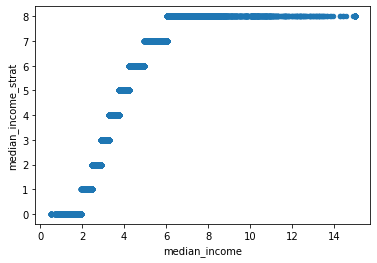

In [5]:
df["median_income_strat"] = 0
i = 0
bins = 10
v = np.percentile(df["median_income"], np.linspace(0, 100, bins))
print(v)
for minn, maxx in zip(v[:-1], v[1:]):
    data = df["median_income"]
    print(minn, maxx, i)
    df.loc[(data >= minn) & (data <= maxx), "median_income_strat"] = i
    i += 1
df.plot(x="median_income", y="median_income_strat", kind="scatter")
df["median_income_strat"].value_counts()

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
spliter = sss.split(df, df["median_income_strat"])
cols = list(df.columns)
cols.remove("median_income_strat")
for train_idx, test_idx in spliter:
    train_set = df[cols].iloc[train_idx]
    test_set = df[cols].iloc[test_idx]

Feature combinations

In [7]:
train_set["rooms_per_household"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_per_room"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set["population_per_household"] = train_set["population"] / train_set["households"]
train_set = train_set.loc[:, list(train_set.columns[train_set.columns != y_col])]
test_set = test_set.loc[:, [y_col]]

Dealing with missing values (impute with median)

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
cols = train_set.columns[train_set.columns != "ocean_proximity"]
imputer.fit(train_set[cols])
# train_set_num = train_set.drop(columns="ocean_proximity", axis=1)
imputer.fit(train_set[cols])
train_set_num = DataFrame(imputer.transform(train_set[cols]), columns=cols)
train_set_num["ocean_proximity"] = train_set.reset_index(drop=True)["ocean_proximity"]
train_set = train_set_num.copy()

In [9]:
train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity
0,-117.41,34.00,26.0,2372.0,621.0,1647.0,612.0,1.4719,3.875817,0.261804,2.691176,INLAND
1,-122.70,38.45,26.0,2011.0,557.0,855.0,530.0,1.1250,3.794340,0.276977,1.613208,<1H OCEAN
2,-122.71,38.43,52.0,1439.0,325.0,738.0,316.0,2.2262,4.553797,0.225851,2.335443,<1H OCEAN
3,-121.33,38.01,27.0,1612.0,234.0,630.0,255.0,5.3180,6.321569,0.145161,2.470588,INLAND
4,-117.64,34.07,52.0,1644.0,372.0,1269.0,355.0,2.6913,4.630986,0.226277,3.574648,INLAND
...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-118.47,34.19,41.0,1104.0,196.0,495.0,196.0,5.0929,5.632653,0.177536,2.525510,<1H OCEAN
16508,-117.77,33.69,15.0,500.0,113.0,261.0,116.0,5.0631,4.310345,0.226000,2.250000,<1H OCEAN
16509,-122.23,37.46,36.0,6090.0,1057.0,3081.0,1075.0,5.6629,5.665116,0.173563,2.866047,NEAR OCEAN
16510,-116.99,33.75,18.0,9601.0,2401.0,4002.0,2106.0,1.4366,4.558879,0.250078,1.900285,INLAND
